# Лабораторная работа №3

## Метод опорных векторов

Выполнила Карасева Екатерина M33351

### Данные

In [1]:
import pandas as pd

data = pd.read_csv('chips.csv')
data.head()

,x,y,class
0,0.051267,0.69956,P
1,-0.092742,0.68494,P
2,-0.213710,0.69225,P
3,-0.375000,0.50219,P
4,-0.513250,0.46564,P


In [2]:
data['class'] = data['class'].apply(lambda x: 1. if x == 'P' else -1.)
data.head()

,x,y,class
0,0.051267,0.69956,1.0
1,-0.092742,0.68494,1.0
2,-0.213710,0.69225,1.0
3,-0.375000,0.50219,1.0
4,-0.513250,0.46564,1.0


In [3]:
import numpy as np


# нормализация
def min_max_normalize(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    return arr.apply(lambda x: (x - arr_min) / (arr_max - arr_min) if arr_max - arr_min != 0 else 1.0)


def normalise(ds):
    for i in ds.columns:
        if i != 'class':
            ds[i] = min_max_normalize(ds[i])


normalise(data)
objects = data.drop(columns='class').to_numpy()
target = data['class'].to_numpy()
data.head()

,x,y,class
0,0.463625,0.782108,1.0
1,0.387869,0.774326,1.0
2,0.324234,0.778217,1.0
3,0.239388,0.677048,1.0
4,0.166662,0.657593,1.0


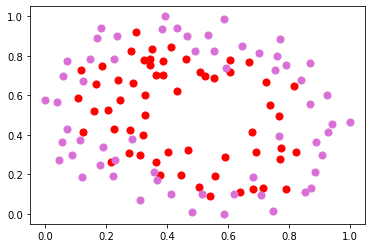

In [4]:
from matplotlib import pyplot as plt

dataset = data.to_numpy()
for i in range(len(dataset)):
    features = dataset[i][:-1]
    label = dataset[i][-1]
    c = 'orchid' if label == -1 else 'red'
    plt.scatter(features[0], features[1], color=c, s=50)
plt.show()

### Реализация алгоритма опорных векторов (встроенная подборка гиперпараметров)

In [5]:
def get_fun(x, y, kernel):
    def fun(alfa):
        summa = 0
        for i in range(0, len(alfa)):
            for j in range(0, len(alfa)):
                summa += alfa[i] * alfa[j] * y[i] * y[j] * kernel(x[i], x[j])
        return - np.sum(alfa) + 1 / 2 * summa

    return fun


def get_constraints(y):
    def fun(alfa):
        return np.sum(alfa * y)

    return fun


from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from statistics import median

def svm(kernel):
    kf = KFold(n_splits=2, shuffle=True)
    C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
    best_accuracy = -1.0
    best_c = 0.05
    for c in C:
        sum_accuracy = 0
        for train_ind, test_ind in kf.split(objects):
            train_x, test_x = objects[train_ind], objects[test_ind]
            train_y, test_y = target[train_ind], target[test_ind]
            train_n, train_m = train_x.shape
            alfa0 = [0] * train_n
            b = [(0, c)] * train_n
            res = minimize(get_fun(train_x, train_y, kernel), alfa0, bounds=b,
                           constraints={'type': 'eq', 'fun': get_constraints(train_y), 'jac': lambda l: train_y})
            cur_alfa = res.x
            cur_w0 = get_w0(cur_alfa, train_x, train_y, kernel)
            cur_classifier = get_classifier(cur_alfa, cur_w0, train_x, train_y, kernel)
            cur_accuracy = get_accuracy(cur_classifier, test_x, test_y)
            sum_accuracy += cur_accuracy
        if sum_accuracy / 2 > best_accuracy:
            best_accuracy = sum_accuracy / 2
            best_c = c
        print(best_c)
    return best_c, best_accuracy


def get_w0(alfa, x, y, kernel):
    n, m = x.shape
    w = [0] * m
    for i in range(0, n):
        w += alfa[i] * y[i] * x[i]
    w0 = []
    for i in range(0, n):
        if alfa[i] > 0 and np.abs(y[i] * kernel(w, x[i]) - 1) < 0.01:
            print('+ new w0')
            w0 = np.append(w0, kernel(w, x[i]) - y[i])
    return median(w0) if len(w0) > 0 else 0


def get_classifier(alfa, w0, x, y, kernel):
    n, m = x.shape

    def fun(test_x):
        summa = 0
        for i in range(0, n):
            summa += alfa[i] * y[i] * kernel(x[i], test_x)
        return np.sign(summa - w0)

    return fun


def get_accuracy(classifier, test_x, test_y):
    pred = []
    for x in test_x:
        pred = np.append(pred, classifier(x))
    return accuracy_score(test_y, pred, normalize=True)

def draw_plot(title, ds, clf):
    plt.title(title)
    min_x1, max_x1 = np.min(ds[:, 0]), np.max(ds[:, 0])
    min_x2, max_x2 = np.min(ds[:, 1]), np.max(ds[:, 1])
    dx1 = max_x1 - min_x1
    dx2 = max_x2 - min_x2
    step1 = 10
    step2 = 60
    for x1 in np.arange(min_x1 - dx1 / step1, max_x1 + dx1 / step1, dx1 / step2):
        for x2 in np.arange(min_x2 - dx2 / step1, max_x2 + dx2 / step1, dx2 / step2):
            z = clf([x1, x2])
            c = 'w'
            c = 'lightcoral' if z == 1 else c
            c = 'lavenderblush' if z == -1 else c
            plt.scatter(x1, x2, color=c, s=150, marker='s')
    for i in range(len(ds)):
        features, label = ds[i][:-1], ds[i][-1]
        c = 'orchid' if label == -1 else 'red'
        plt.scatter(features[0], features[1], color=c, s=50)
    plt.show()

def get_classifier_with_params(c, kernel, x, y) :
    n, m = x.shape
    alfa0 = [0] * n
    b = [(0, c)] * n
    res = minimize(get_fun(x, y, kernel), alfa0, bounds=b,
                   constraints={'type': 'eq', 'fun': get_constraints(y), 'jac': lambda l: y})
    alfa = res.x
    print('alfa = ' + str(alfa))
    w0 = get_w0(alfa, x, y, kernel)
    return get_classifier(alfa, w0, x, y, kernel)

### Линейное ядро

In [6]:
linear_classifier = get_classifier_with_params(svm(np.dot)[0], np.dot, objects, target)
# linear_classifier = get_classifier_with_params(0.1, np.dot, objects, target)
draw_plot('linear', dataset, linear_classifier)

0.05
0.1
0.1
0.1
0.1
0.1
0.1
0.1
alfa = [0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.0368878 0.0631122 0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.1       0.1       0.1       0.1
 0.1       0.1       0.1       0.        0.1      

0.05
0.05
0.05
+ new w0
0.05
0.05
0.05
0.05
0.05
best_degree = 2
0.05
0.05
0.05
0.05
5.0
5.0
5.0
5.0
best_degree = 3
0.05
0.05
0.05
0.05
5.0
5.0
5.0
5.0
best_degree = 3
0.05
0.05
0.5
0.5
0.5
0.5
0.5
0.5
best_degree = 3
polynomial params: c = 5.0 d = 3
alfa = [5.00000000e+00 5.00000000e+00 5.00000000e+00 5.00000000e+00
 5.00000000e+00 5.00000000e+00 0.00000000e+00 0.00000000e+00
 5.00000000e+00 5.00000000e+00 5.00000000e+00 5.00000000e+00
 5.00000000e+00 5.00000000e+00 5.00000000e+00 5.00000000e+00
 5.00000000e+00 5.00000000e+00 5.00000000e+00 5.00000000e+00
 5.00000000e+00 5.00000000e+00 0.00000000e+00 0.00000000e+00
 1.45828823e-12 5.00000000e+00 5.00000000e+00 5.00000000e+00
 5.00000000e+00 5.00000000e+00 5.00000000e+00 5.00000000e+00
 5.00000000e+00 5.00000000e+00 5.00000000e+00 4.77136761e+00
 0.00000000e+00 5.00000000e+00 5.00000000e+00 5.00000000e+00
 5.00000000e+00 5.00000000e+00 5.00000000e+00 5.00000000e+00
 5.00000000e+00 5.00000000e+00 5.00000000e+00 5.00000000e+00
 5.000000

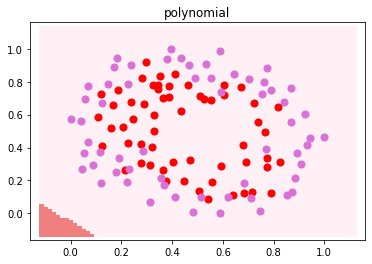

In [8]:
def polynomial_kernel(degree):
    def kernel(x, y):
        return np.dot(np.transpose(x), y) ** degree

    return kernel

def get_polynomial_classifier() :
    best_accuracy = -1.0
    best_degree = 2
    best_c = 0.05
    D = [2, 3, 4, 5]
    for degree in D :
        c, accuracy = svm(polynomial_kernel(degree))
        if accuracy > best_accuracy :
            best_accuracy = accuracy
            best_degree = degree
            best_c = c
        print('best_degree = ' + str(best_degree))
    print('polynomial params: c = ' + str(best_c) + ' d = ' + str(best_degree))
    return get_classifier_with_params(best_c, polynomial_kernel(best_degree), objects, target)

polynomial_classifier = get_polynomial_classifier()
draw_plot('polynomial', dataset, polynomial_classifier)

0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
best_beta = 1
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
best_beta = 1
0.05
0.1
0.5
0.5
0.5
0.5
0.5
0.5
best_beta = 1
0.05
0.05
0.05
0.05
+ new w0
0.05
0.05
0.05
0.05
best_beta = 1
0.05
0.05
0.05
0.05
0.05
0.05
0.05
0.05
best_beta = 5
gaussian params: c = 0.05 d = 5
alfa = [0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.01851047
 0.05       

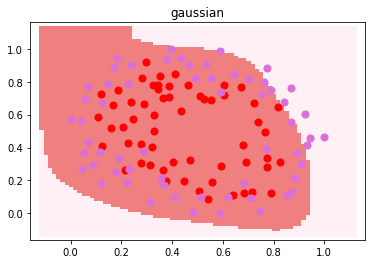

In [6]:
def gaussian_kernel(beta):
    def kernel(x, y):
        return np.exp(-beta * np.linalg.norm((x - y) ** 2))

    return kernel

def get_gaussian_classifier() :
    best_accuracy = -1.0
    best_beta = 2
    best_c = 0.05
    B = [1, 2, 3, 4, 5]
    for beta in B :
        c, accuracy = svm(gaussian_kernel(beta))
        if accuracy > best_accuracy :
            best_accuracy = accuracy
            best_beta = beta
            best_c = c
        print('best_beta = ' + str(best_beta))
    print('gaussian params: c = ' + str(best_c) + ' d = ' + str(best_beta))
    return get_classifier_with_params(best_c, gaussian_kernel(best_beta), objects, target)

gaussian_classifier = get_gaussian_classifier()
# gaussian_classifier = get_classifier_with_params(5.0, gaussian_kernel(5), objects, target)
draw_plot('gaussian', dataset, gaussian_classifier)